# Project : Implement simple ML models for activity recognition with accelerometer data

## Load dataset

In [5]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import random
random.seed(7)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

The dataset used is located at : https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

Dowlad the dataset, and extract in project directory.

In [36]:
import os
import zipfile
import requests

# URL of zip file
zip_url = "https://archive.ics.uci.edu/static/public/341/smartphone+based+recognition+of+human+activities+and+postural+transitions.zip"

# Name of zip file
zip_path = "smartphone+based+recognition+of+human+activities+and+postural+transitions.zip"

# Download zip file
response = requests.get(zip_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract in data folder 
extract_path = "./data/"  # Modifier selon le dossier cible
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)
    
# Look for another ZIP inside the extracted folder
for root, _, files in os.walk(extract_path):
    for file in files:
        if file.endswith(".zip"):
            nested_zip_path = os.path.join(root, file)
            print(f"Extracting nested ZIP: {nested_zip_path}")

            # Step 3: Extract the nested ZIP in the same directory
            with zipfile.ZipFile(nested_zip_path, "r") as nested_zip_ref:
                nested_zip_ref.extractall(root)

            # Step 4: Remove the nested ZIP after extraction
            os.remove(nested_zip_path)
            print(f"Deleted nested ZIP: {nested_zip_path}")

# Supprimer le fichier ZIP après extraction
os.remove(zip_path)

print("Dataset downloaded, and put in data folder ✅")


Dataset downloaded, and put in data folder ✅


Load the accelerometer and gyroscope data. We read the features names from `features.txt` nad the activity labels from `activity_labels.txt`


In [37]:
dataset_path = "data/"
with open(f"{dataset_path}/features.txt") as f:
    features = f.read().split()
print(f"Number of features: {len(features)}")
with open(f"{dataset_path}/activity_labels.txt") as f:
    activity_labels = f.readlines()
activity_df = [x.split() for x in activity_labels]
print(f"Number of activities: {len(activity_labels)}")
pd.DataFrame(activity_df, columns = ['Activity_id', 'Activity_label'])

Number of features: 561
Number of activities: 12


,Activity_id,Activity_label
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING
6,7,STAND_TO_SIT
7,8,SIT_TO_STAND
8,9,SIT_TO_LIE
9,10,LIE_TO_SIT


In [3]:
activity_labels

['1 WALKING\n',
 '2 WALKING_UPSTAIRS\n',
 '3 WALKING_DOWNSTAIRS\n',
 '4 SITTING\n',
 '5 STANDING\n',
 '6 LAYING\n']

The data is already pre-splitted into train and test sets. We can use the train set to train the model, and the test set to evaluate the model.

In [38]:
# Define the file paths
input_file = f"{dataset_path}/Train/X_train.txt"
output_file = f"{dataset_path}/Train/X_train_cleaned.txt"

# Open the file, replace double spaces, and save it
with open(input_file, "r") as file:
    content = file.read().strip().replace("\n  ", "\n").replace("\n ", "\n")
    content = content.replace("  ", ";")  # Replace double spaces with single space
    content = content.replace(" ", ";")

with open(output_file, "w") as file:
    file.write(content)

In [40]:
X_train = pd.read_csv(f"{dataset_path}/Train/X_train.txt", header = None, sep = " ")
X_train.columns = features
X_train.iloc[:10, :10].head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1
0,0.044,-0.006,-0.035,-0.995,-0.988,-0.937,-0.995,-0.989,-0.953,-0.795
1,0.039,-0.002,-0.029,-0.998,-0.983,-0.971,-0.999,-0.983,-0.974,-0.803
2,0.040,-0.005,-0.023,-0.995,-0.977,-0.985,-0.996,-0.976,-0.986,-0.798
3,0.040,-0.012,-0.029,-0.996,-0.989,-0.993,-0.997,-0.989,-0.993,-0.798
4,0.039,-0.002,-0.024,-0.998,-0.987,-0.993,-0.998,-0.986,-0.994,-0.802


In [50]:
y_train = pd.read_csv(f"{dataset_path}/Train/y_train.txt", header = None, sep = " ", names = ['Activity_id'])
y_train    

,Activity_id
0,5
1,5
2,5
3,5
4,5
...,...
7762,2
7763,2
7764,2
7765,2


In [48]:
X_test = pd.read_table(f"{dataset_path}/Test/X_test.txt", header = None, sep = " ")
X_test.columns = features
X_test.iloc[:10, :10].head()

,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1
0,0.031,-0.009,0.040,-0.939,-0.945,-0.759,-0.952,-0.950,-0.802,-0.757
1,0.043,0.001,-0.026,-0.976,-0.978,-0.960,-0.987,-0.979,-0.967,-0.757
2,0.038,-0.012,-0.026,-0.994,-0.979,-0.973,-0.994,-0.981,-0.978,-0.799
3,0.036,-0.018,-0.025,-0.995,-0.982,-0.976,-0.995,-0.983,-0.981,-0.798
4,0.038,-0.013,-0.033,-0.994,-0.977,-0.984,-0.994,-0.977,-0.986,-0.798


In [49]:
y_test = pd.read_table(f"{dataset_path}/Test/y_test.txt", header = None, sep = " " , names = ['Activity_id']) 
y_test

,Activity_id
0,5
1,5
2,5
3,5
4,5
...,...
3157,2
3158,2
3159,2
3160,2


## Human activity classification
We will use the python library scikit-learn, in order to predict the activity from the features.
We will also use **5-fold cross-validation (CV)** to evaluate the model performance. We will use a **linear kernel** in order to classify the activities, and a **0.1 C value** to train the model.

### 1. Linear Support Vector Classification

`hyper-parameters` : Settings that you can configure to control the behavior of the learning algorithm. Not learned from the data, but set prior to the training process.
Here we use C (Regularization Parameter), which controls the trade-off between achieving a low training error and a low testing error.


In [53]:
from sklearn.svm import LinearSVC # Support Vector Classifier
from sklearn.model_selection import validation_curve  # Validation Curve

# Yper-parameter C
C_params = np.logspace(-6, 3, 10)

# Declare the classfier
clf_svc = LinearSVC(random_state = 7) # set the seed for random number to 7 (for reproducibility)

# Compute training and test scores for varying parameter values
train_scores, val_scores = validation_curve(
    clf_svc, X_train, y_train.values.flatten(),
    param_name = "C", param_range = C_params,
    cv = 5, scoring = "accuracy", n_jobs = -1
)



/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

##### Plotting the learning curve

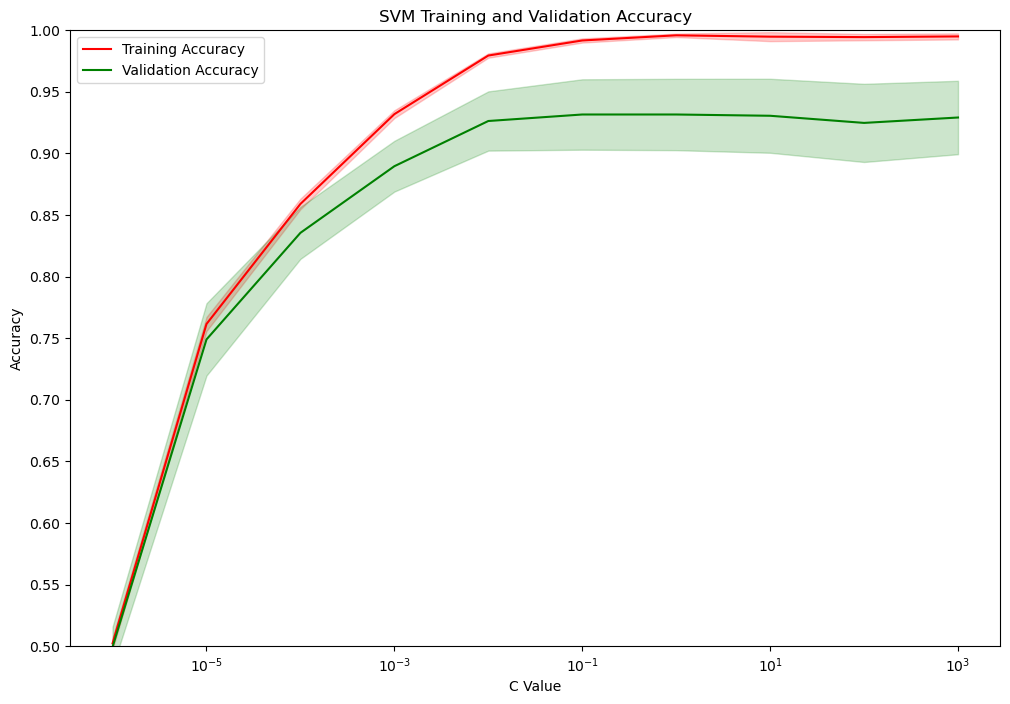

In [54]:
def plot_accuracy(train_scores, val_scores, C_params):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    # To better visualize the plot, we set the y-axis limits
    y_min = 0.5
    y_max = 1.0

    f = plt.figure(figsize = (12, 8))
    ax = plt.axes()
    plt.title("SVM Training and Validation Accuracy")
    plt.xlabel("C Value")
    plt.ylabel("Accuracy")
    plt.ylim(y_min, y_max)
    plt.yticks(np.arange(y_min, y_max + .01, .05))
    plt.semilogx(C_params, train_scores_mean, label = "Training Accuracy", color = "red")
    plt.fill_between(C_params, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha = 0.2, color = "red")
    plt.semilogx(C_params, val_scores_mean, label = "Validation Accuracy",
                 color = "green")
    plt.fill_between(C_params, val_scores_mean - val_scores_std,
                     val_scores_mean + val_scores_std, alpha = 0.2, color = "green")
    plt.legend(loc = "best")

    plt.show()
    
plot_accuracy(train_scores, val_scores, C_params)

From the graph, it looks like the best value of C is at 0.1. The validation accuracy begins slowly decreasing after that 0.1, indicating that we are starting to overfit.

In [55]:
print("The mean validation score is {:.4f}".format(np.max(np.mean(val_scores, axis=1))))

The mean validation score is 0.9315


Currently, all the features are used in the model. We can try to reduce the number of features to see if we can improve the model performance.

In [57]:
print(f"Number of features : {len(features)}")

Number of features : 561


Lets only select the first 40 features

In [58]:
features[0:40]

['tBodyAcc-Mean-1',
 'tBodyAcc-Mean-2',
 'tBodyAcc-Mean-3',
 'tBodyAcc-STD-1',
 'tBodyAcc-STD-2',
 'tBodyAcc-STD-3',
 'tBodyAcc-Mad-1',
 'tBodyAcc-Mad-2',
 'tBodyAcc-Mad-3',
 'tBodyAcc-Max-1',
 'tBodyAcc-Max-2',
 'tBodyAcc-Max-3',
 'tBodyAcc-Min-1',
 'tBodyAcc-Min-2',
 'tBodyAcc-Min-3',
 'tBodyAcc-SMA-1',
 'tBodyAcc-Energy-1',
 'tBodyAcc-Energy-2',
 'tBodyAcc-Energy-3',
 'tBodyAcc-IQR-1',
 'tBodyAcc-IQR-2',
 'tBodyAcc-IQR-3',
 'tBodyAcc-ropy-1',
 'tBodyAcc-ropy-1',
 'tBodyAcc-ropy-1',
 'tBodyAcc-ARCoeff-1',
 'tBodyAcc-ARCoeff-2',
 'tBodyAcc-ARCoeff-3',
 'tBodyAcc-ARCoeff-4',
 'tBodyAcc-ARCoeff-5',
 'tBodyAcc-ARCoeff-6',
 'tBodyAcc-ARCoeff-7',
 'tBodyAcc-ARCoeff-8',
 'tBodyAcc-ARCoeff-9',
 'tBodyAcc-ARCoeff-10',
 'tBodyAcc-ARCoeff-11',
 'tBodyAcc-ARCoeff-12',
 'tBodyAcc-Correlation-1',
 'tBodyAcc-Correlation-2',
 'tBodyAcc-Correlation-3']

/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

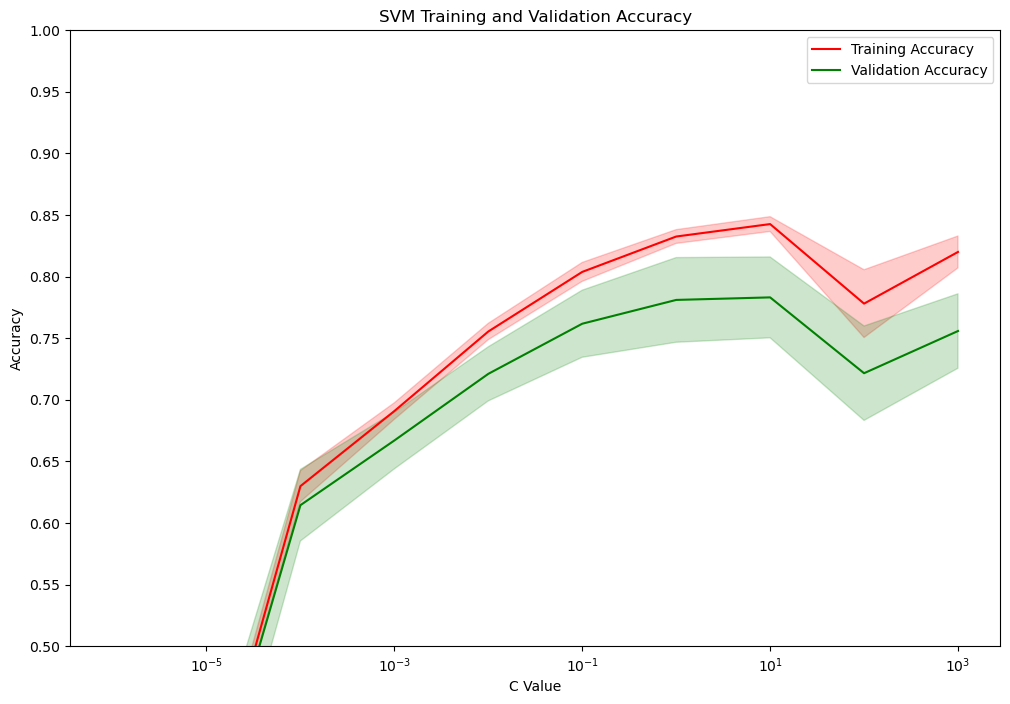

In [59]:
X_train_new = X_train.iloc[:,0:40]
X_test_new = X_test.iloc[:,0:40]

# Compute training and test scores for varying parameter values
train_scores, val_scores = validation_curve(
    clf_svc, X_train_new.values, y_train.values.flatten(),
    param_name = "C", param_range = C_params,
    cv = 5, scoring = "accuracy", n_jobs = -1
)

plot_accuracy(train_scores, val_scores, C_params)

The classifier performs worse (as expected, since the feature set is not well selected).
We need to select appropriate features. For that we can use advanded functions in scikit-learn.

In [60]:
from sklearn.feature_selection import SelectKBest

# SelectKBest aims to reduce the dimensionality of the dataset by selecting the best k features
# It is using ANOVA score by default
feature_selector = SelectKBest(k=20).fit(X_train.values, y_train.values.flatten())
X_train_new = feature_selector.transform(X_train.values)
X_test_new = feature_selector.transform(X_test.values)

/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/daoliangshu/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

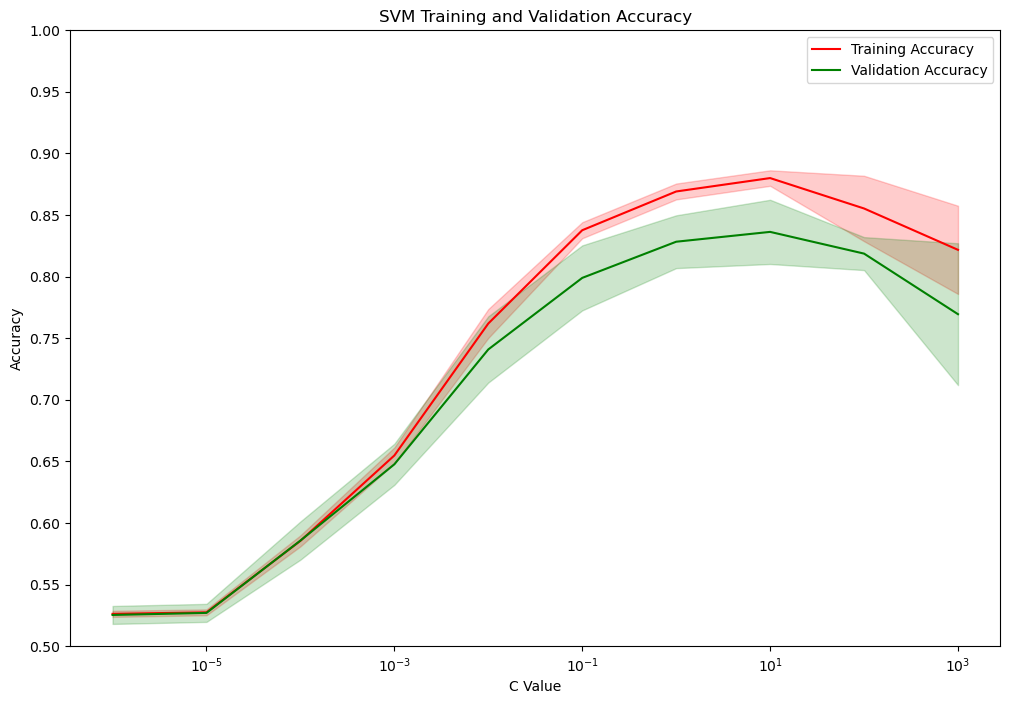

In [61]:
# Compute training and test scores for varying parameter values
train_scores, val_scores = validation_curve(
    clf_svc, X_train_new, y_train.values.flatten(),
    param_name = "C", param_range = C_params,
    cv = 5, scoring = "accuracy", n_jobs = -1)

plot_accuracy(train_scores, val_scores, C_params)

We see choosing the 20 best features is stil not enough. The performance is worse than including all the features.
We could try increasing the number of features to see if there is a subset of features which can perform better than including all the features.

## Grid Search CV

In [62]:
# import the functions SVC and GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Declare the parameters
# - Pay attention to the number of paramters you declare.
# - More points in the GridSearch will cost you longer training time.

# List of parameters
# - kernel: Type of the kernel function
#           {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
# - C: The amount of regularization
param_C = np.logspace(-6, 3, 5)
parameters = [{'kernel': ['rbf'], 'C': param_C},
              {'kernel': ['poly'], 'C': param_C, 'degree': [2,3,4]}]

# Declare the classifier (estimator) to be used in GridSearchCV
clf_svc = SVC(random_state = 7)

# Declare the classifier using GridSearchCV
clf_GSCV = GridSearchCV(estimator = clf_svc, param_grid = parameters, cv = 5, n_jobs = -1)

In [63]:
# This process can take around 30 minutes
# Fit the classifier and find the best parameters using GridSearchCV
clf_GSCV.fit(X_train.values, y_train.values.flatten())

GridSearchCV(cv=5, estimator=SVC(random_state=7), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-06, 1.77827941e-04, 3.16227766e-02, 5.62341325e+00,
       1.00000000e+03]),
                          'kernel': ['rbf']},
                         {'C': array([1.00000000e-06, 1.77827941e-04, 3.16227766e-02, 5.62341325e+00,
       1.00000000e+03]),
                          'degree': [2, 3, 4], 'kernel': ['poly']}])

In [64]:
# Which one is the best model and the best parameter? What's the best CV score you got?
# (Hint: read the list of Attributes in the documentation page of GridSearchCV on scikit-learn)
print(clf_GSCV.best_params_)
print(clf_GSCV.best_score_)

# Predict on test data using the best model
clf_GSCV.score(X_test.values, y_test)

{'C': 1000.0, 'kernel': 'rbf'}
0.9380786637064809


0.9538266919671095

### Decision Tree

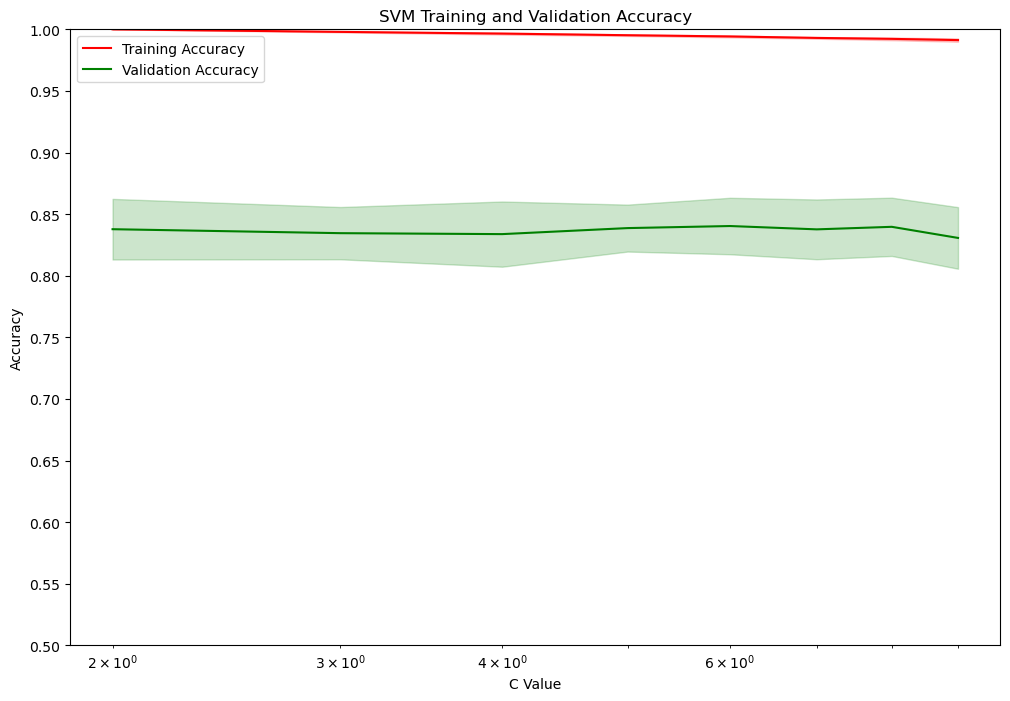

In [65]:
# Now try other classifiers, for example Decision Trees, Nearest Neighbors, or Ensemble methods. Can you get better results?
# After identifying the best model with the optimal set of parameters, test your model using the test set. 
# What's your test accuracy? Are you satisfied? How complex is your model to be deployed on a microcontroller?

# A possible solution:

# Import the classifier
from sklearn.tree import DecisionTreeClassifier

# Declare the classifier
classifier = DecisionTreeClassifier(random_state=7)

# Declare the parameter
# - min_samples_split: The minimum number of samples to split an internal node
min_samp_split = np.arange(2,10)

# Let's use validation curve
train_scores, val_scores = validation_curve(
    classifier, X_train.values, y_train.values.flatten(),
    param_name = "min_samples_split", param_range = min_samp_split,
    cv = 5, scoring = "accuracy", n_jobs = -1)

plot_accuracy(train_scores, val_scores, min_samp_split)

From the graph, we can see that the accuracy does not exceed 85%. It does not perform as well as SVM

In [66]:
clf_svc = LinearSVC(C=0.1, random_state = 7)
clf_svc.fit(X_train.values, y_train.values.flatten())
print("The test accuracy is {:.2f}%".format(clf_svc.score(X_test.values, y_test.values.flatten())*100))


The test accuracy is 94.72%
